# Author
- Neha Bhoi & Liam Nguyen
- CECS 550 - Pattern Recognition (Spring 2020)
- Final Project: Build Random Forest Model and Evaluate [Cancer Data](http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))

# Import

In [2]:
import pandas as pd
from math import sqrt
from random import seed, randrange
import statistics
import sys
from IPython.display import display
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import seaborn as sns; 

# Load Data

In [3]:
seed(2)
sns.set(style='white')

# Constants
TRAIN_TEST_RATIO = 0.7 
N_FOLD = 5 
TREES_COUNT = 20
MAX_DEPTH = 7
MIN_SIZE = 10
SAMPLE_RATIO = 1

# DATA
data = pd.read_csv("./data.csv")
print("Dimensions:", data.shape)
display(data)

Dimensions: (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# Data Processing
- Drop ID Column since it's not relevant for our model 
- Change diagnosis column from label to numeric value

In [4]:
data.drop(['id'], axis=1, inplace=True)
data['diagnosis'] = data['diagnosis'].map({'M': 1,'B':0})
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Visualize Data

## Count of each diagnosis

In [26]:
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

## Historgram of each feature

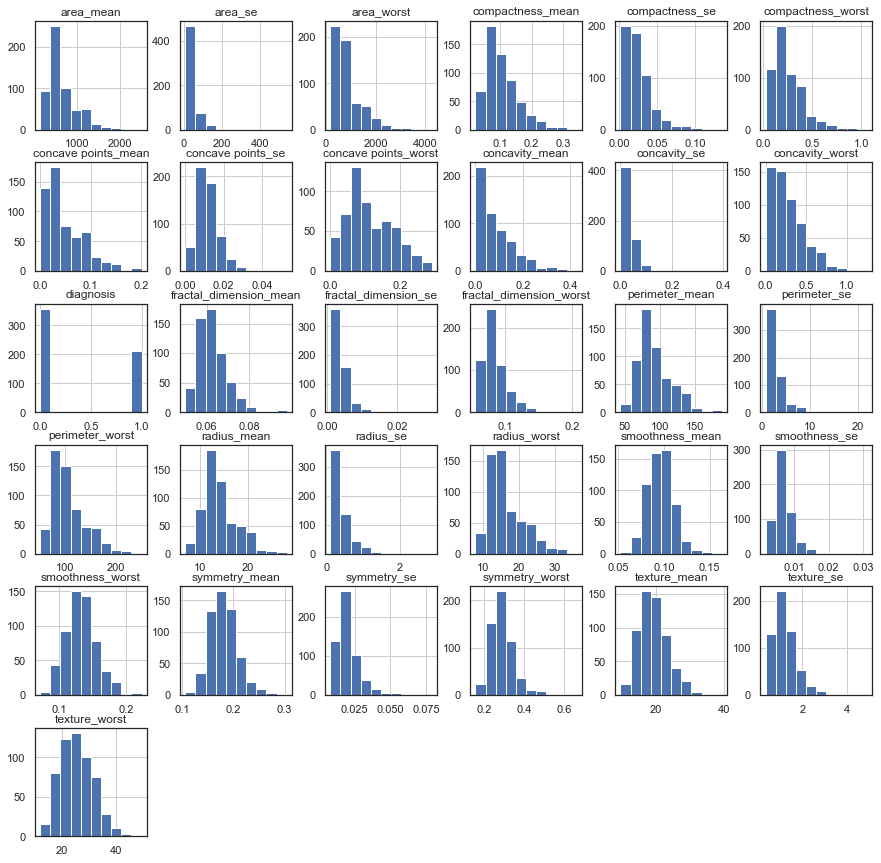

In [13]:
 pd.DataFrame.hist(data, figsize = [15,15]);

## Statistic Summary of Each Feature

In [25]:
data.loc[:, list(data.columns[1:])].describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Heat Map To Show The Correlation Between Features
- The redder the color is, the stronger positive correlation value between two features. 
- The bluer the color is, the stornger negative correlation value between two features.
- The correlation between a feature to itself is 1 which is the highest.

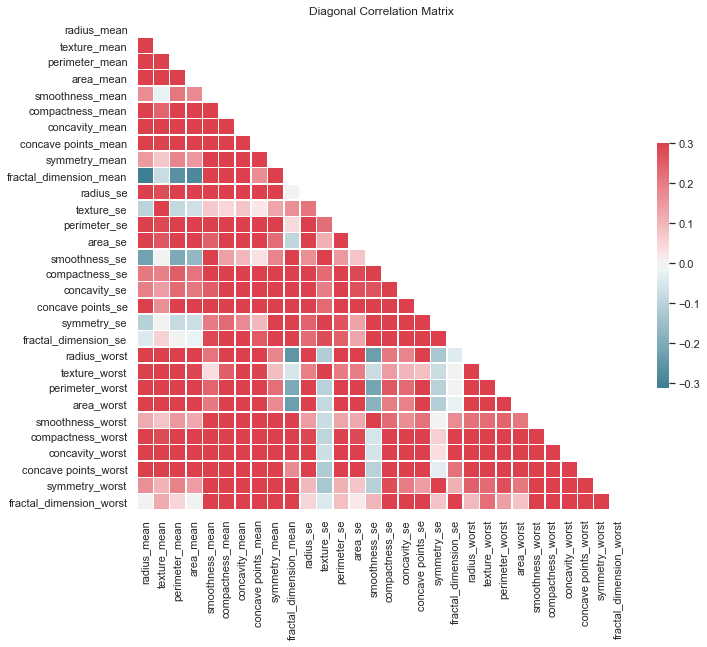

In [9]:
def create_heatmap(corr_matrix, title): 
    # Generate correlation matrix
#     corr_mat = data.loc[:, list(data.columns[1:])].corr()  # skip diagnosis column
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool)) 
    # Setup the mathplotlib figure
    f, ax = plt.subplots(figsize=(11, 9)) 
    # Setup a custome divering colormap 
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title(title)
    plt.show()

# # Generate correlation matrix
# corr_mat = data.loc[:, list(data.columns[1:])].corr()  # skip diagnosis column
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr_mat, dtype=np.bool)) 
# # Setup the mathplotlib figure
# f, ax = plt.subplots(figsize=(11, 9)) 
# # Setup a custome divering colormap 
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Diagonal Correlation Matrix")
# plt.show()

corr_mat = data.loc[:, list(data.columns[1:])].corr()  # skip diagnosis column
create_heatmap(corr_mat, title="Diagonal Correlation Matrix")

### Obvervation from Heat Map: 
- As we can see from the graph, most of the features have strong positive correlation pair-wise. 
- 5 features that doesn't have a strong correlations are: texture_se, smoothness, symmetry, fractal dimension_se to radius_mean, texture_mean, perimeter_mean, area_mean

# Model
## Decision Tree

In [13]:
## Build a tree. The root node is create from a random feature from [1...n] where n = # of feature. 
## Index 0 is reserved for label.
def build_tree(dataset, min_sample_size, max_depth):
    random_index = randrange(1, len(dataset[0])) # 0 index is the label
    root = build_node(dataset, random_index)
    build_children(root, max_depth, min_sample_size, 1) 
    return root

# Build a node. A node contains: index, value, groups (this will be removed by children)
def build_node(dataset, index):
    class_labels = list(set([row[0] for row in dataset]))
    node_index, node_value, best_gini_gained, node_groups = -1, -1, -1, None
    # Test use each row[index] to find the best split for gini impurity gained. 
    for row in dataset:
        groups = split_groups(index, row[index], dataset) 
        gini_gained = calc_gini_gained(groups, class_labels)
        if gini_gained > best_gini_gained:
            node_index = index
            node_value = row[index]
            best_GI_score = gini_gained
            node_groups = groups
    return {'index': node_index, 'value': node_value, 'groups': node_groups}    

# Split to left and right by value
def split_groups(index, value, dataset):
    left = []
    right = []
    for row in dataset:
        if row[index] < value: 
            left.append(row)
        else: 
            right.append(row)
    return left, right

# Calculate impurity of parent = (1 - sum(p^2)) for each class label
def calc_gini_parent(groups, class_labels):
    all_rows = [row for group in groups for row in group]
    size = len(all_rows)
    score = 0
    for label in class_labels:
        p = [row[0] for row in all_rows].count(label) / size
        score += p * p;
    return 1 - score

# Calculate impurity for the split = parent impurity - sum of child impurities
def calc_gini_gained(groups, classes):
    parent_size = float(sum([len(group) for group in groups]))
    gini_gained = calc_gini_parent(groups, classes)
    for group in groups:
        group_size = float(len(group))
        # avoid divide by zero
        if group_size == 0:
            continue
        group_score = 0.0 # accumulate score of each group
        for class_val in classes:
            p = [row[0] for row in group].count(class_val) / group_size
            group_score += p * p
        # weight the group score by its relative size
        gini_gained -= (1.0 - group_score) * (group_size / parent_size)
    return gini_gained

def build_children(node, max_depth, min_size, depth): 
    left, right = node['groups'] # Extract groups information from parent node
    del node['groups'] # Remove groups
    
    # If parent node is empty
    if not left or not right: 
        node['left'] = node['right'] = build_terminal_node(left + right)
        return 
    
    # if max depth is reached
    if depth >= max_depth:
        node['left'] = build_terminal_node(left)
        node['right'] = build_terminal_node(right)
        return 
    
    # For left child: 
    ## Too little sample
    if (len(left) <= min_size):
        node['left'] = build_terminal_node(left)
    else:
        random_index = randrange(1, len(left[0])) 
        node['left'] = build_node(left, random_index)
        build_children(node['left'], max_depth, min_size, depth + 1)
    if (len(right) <= min_size):
        node['right'] = build_terminal_node(right)
    else:
        random_index = randrange(1, len(right[0]))
        node['right'] = build_node(right, random_index)
        build_children(node['right'], max_depth, min_size, depth + 1)

def build_terminal_node(group):
    labels = [row[0] for row in group]
    return max(set(labels), key=labels.count)

def predict_from_tree(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict): # check if it's terminal
            return predict_from_tree(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict): # check if it's terminal
            return predict_from_tree(node['right'], row)
        else:
            return node['right']

## Random Forest

In [14]:
## Forest
def build_forest(train, n_trees, max_depth=5, min_size=1, sample_ratio=1):
    trees = []
    for i in range(n_trees):
        sample = []
        n_sample = len(train) * sample_ratio
        while len(sample) < n_sample:
            index = randrange(len(train))
            sample.append(train[index])
        tree = build_tree(sample, min_size, max_depth)
        trees.append(tree)
    return trees

def random_forest(train, test, n_trees=5, max_depth=5, min_size=1, sample_ratio=1):
    trees = build_forest(train, n_trees, max_depth=5, min_size=1, sample_ratio=1)
    predictions = []
    for row in test:
        row_prediction = [predict_from_tree(tree, row) for tree in trees]
        predictions.append(max(set(row_prediction), key=row_prediction.count))
    return predictions

## Utilities

In [15]:
## Evaluation
# Split data in particular ratio for train and test
def split_data(data, ratio=0.7):
    shuffle_df = data.sample(frac=1)
    train_size = int(ratio * len(data))
    train_set = shuffle_df[:train_size]
    test_set = shuffle_df[train_size:]
    return train_set, test_set

## Perform cross validation split
def cross_validation_split(dataframe, n_folds):
    dataframe_split = list()
    dataframe_copy = dataframe
    for i in range(n_folds):
        left_fold = n_folds - i
        fold_fraction = float(1/left_fold)
        fold = dataframe_copy.sample(frac=fold_fraction)
        dataframe_split.append(fold)
        dataframe_copy = dataframe_copy.drop(fold.index)
    return dataframe_split

## Evaluate Random Forest algorithm
def evaluate_algorithm(dataframe, n_folds, algo, *args):
    confusion_matrices = []
    folds = cross_validation_split(dataframe, n_folds)
    for i in range(len(folds)):
        l_without_i = folds[:i] + folds[(i + 1):]
        train = pd.concat(l_without_i)
        test = folds[i]
        test_labels = [row[0] for row in test.values.tolist()]
        predictions = algo(train.values.tolist(), test.values.tolist(), *args)
        matrix = confusion_matrix(test_labels, predictions)
        confusion_matrices.append(matrix)
        print("Completed cross-test ", i + 1, ", remained: ", len(folds) - i - 1, end="\r")
   
    # Generate dataframe for statistic summary  
    labels = ["Accuracy", "Recall", 
              "False Positive", "Precision", "F1 Score"]
    stats = [[calc_accuracy(mat.values.tolist()), 
              calc_recall(mat.values.tolist()), 
              calc_false_positive(mat.values.tolist()), 
              calc_precision(mat.values.tolist()),
              calc_f1(mat.values.tolist())
             ] for mat in confusion_matrices]
    
    summary_df = pd.DataFrame(data=stats, columns=labels) 
    # Shift index by 1, index = cross-test number 
    summary_df.index += 1
    # Generate average for each stat
    summary_df.loc['Average'] = summary_df.mean(numeric_only=True, axis=0)
    
    return summary_df

## Generate Confusion Matrix
def confusion_matrix(test, predicted):
    test = list(map( lambda x: int(x), test))
    predicted = list(map(lambda x: int(x), predicted))
    y_actu = pd.Series(test, name='Actual')
    y_pred = pd.Series(predicted, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    #Predicted        0        1
    #Actual
    # 0              TN        FP
    # 1              FN        TP
    return df_confusion

def calc_accuracy(matrix):
    #AC = (TN + TP) / (TN + FP + FN + TP)
    return (matrix[0][0] + matrix[1][1]) * 1.0 / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])
    
def calc_recall(matrix):
    #TPR = TP / (FN + TP)
    return matrix[1][1]  * 1.0 / (matrix[1][0] + matrix[1][1])

def calc_false_positive(matrix):
    #TNR = FP / (TN + FP)
    return matrix[0][1]  * 1.0 / (matrix[0][0] + matrix[0][1])
    
def calc_precision(matrix):
    #precision = TP / (FP + TP)
    return matrix[1][1]  * 1.0 / (matrix[0][1] + matrix[1][1])

def calc_f1(matrix): 
    # f1 = 2 * (precision * recall) / (precision + recall) 
    precision = calc_precision(matrix)
    recall = calc_recall(matrix)
    return (2 * (precision * recall)  * 1.0 / (precision + recall))

# Evaluation of Our Model 
## Our Model From Scratch
### Parameter
- TRAIN_TEST_RATIO = 0.7 
- N_FOLD = 5 
- TREES_COUNT = 20
- MAX_DEPTH = 7
- MIN_SIZE = 10
- SAMPLE_RATIO = 1

In [9]:
result = evaluate_algorithm(data, N_FOLD, random_forest, TREES_COUNT, MAX_DEPTH, MIN_SIZE, SAMPLE_RATIO)
print("\n\nSummary of", N_FOLD, "folds cross-validation is:\n")
display(result)

Completed cross-test  5 , remained:  0

Summary of 5 folds cross-validation is:



,Accuracy,Recall,False Positive,Precision,F1 Score
1,0.859649,0.687500,0.015152,0.970588,0.804878
2,0.903509,0.750000,0.013514,0.967742,0.845070
3,0.964912,0.973684,0.039474,0.925000,0.948718
4,0.912281,0.829787,0.029851,0.951220,0.886364
5,0.929204,0.820513,0.013514,0.969697,0.888889
Average,0.913911,0.812297,0.022301,0.956849,0.874784


### Report
- As we see in the result, we have ~95% of precision, ~81% of recall and 91% accuracy.
- With relative high recall value, our model leave out 20% positive cases that are mislabeled as negative. 
- With the high precision value, our model also has low cases where non-cancer is labelled as cancer. 
- Combined recall and precision, our F1 score is ~87% which is a balanced classification model with optimal balance of recall and precision. 
- This shows that Random Forest Classifier is a right choice for this dataset.

## Fine Tune Model With Feature Importance
### Analysis

In [16]:
# Feature Importance
def display_gini_Importance_features(data,ration):
    X = data.iloc[:,1:31]
    # Create a list of feature names
    feat_labels = X.columns
    
    Y = data.iloc[:,0]
    
    # Split the data into 30% test and 70% training
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=ration, random_state=0)
    
    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    features_df = pd.DataFrame(data=clf.feature_importances_, index=X.columns, columns=['score'])
    sorted_features_df = features_df.sort_values(by=['score'], ascending=False)
    sorted_features_df.plot.bar().set_title("Feature Important Score")
    plt.show()
    return sorted_features_df

### List and Graph of All Feature Importance (Descending Order)

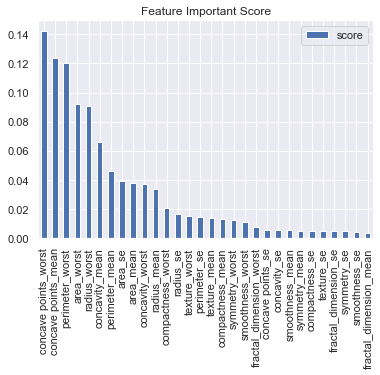

,score
concave points_worst,0.142459
concave points_mean,0.124031
perimeter_worst,0.120270
area_worst,0.092017
radius_worst,0.091058
concavity_mean,0.066016
perimeter_mean,0.045964
area_se,0.038880
area_mean,0.037878
concavity_worst,0.036824


The scores above are the importance scores for each variable. All scores add up to 100%.


In [28]:
display(display_gini_Importance_features(data, 0.3))
print("The scores above are the importance scores for each variable. All scores add up to 100%.")

### Run Our Model With Only Feature Importance > 0.0100
#### Parameters
- TRAIN_TEST_RATIO = 0.7 
- N_FOLD = 5 
- TREES_COUNT = 20
- MAX_DEPTH = 7
- MIN_SIZE = 10
- SAMPLE_RATIO = 1
- THRESHOLD >= 0.010 (For Feature Importance Value)

In [17]:
def get_gini_Importance_features(data,ration,threshold):
    X = data.iloc[:,1:31]
    # Create a list of feature names
    feat_labels = X.columns
    
    Y = data.iloc[:,0]
    
    # Split the data into 40% test and 60% training
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=ration, random_state=0)
    
     # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Create a selector object that will use the random forest classifier to identify
    # features that have an importance of more than 0.010
    sfm = SelectFromModel(clf, threshold=threshold)

    # Train the selector
    sfm.fit(X_train, y_train)
    
    # Print the names of the most important features
    important_feature_list = [feat_labels[index] for index in sfm.get_support(indices=True)]
    print(f"Important features with at least {threshold} are:\n")
    pprint(important_feature_list)
    print("Total considered features:", len(important_feature_list))
    return ['diagnosis'] + important_feature_list

def execute_algo_with_important_features(data):
    #get important features list
    important_feature_list = get_gini_Importance_features(data, ration = 0.3, threshold = 0.010)
    
    #transform data to important feature
    important_feature_data = data[important_feature_list]
    
    # Create a new random forest classifier for the most important features
    print("\nExecute Random forest only with imporatant feature:\n")
    return evaluate_algorithm(important_feature_data, N_FOLD, random_forest, TREES_COUNT, MAX_DEPTH, MIN_SIZE, SAMPLE_RATIO)

display(execute_algo_with_important_features(data))

Important features with at least 0.01 are:

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst']
Total considered features: 19

Execute Random forest only with imporatant feature:



,Accuracy,Recall,False Positive,Precision,F1 Score
1,0.938596,0.840909,0.000000,1.000000,0.913580
2,0.964912,0.909091,0.000000,1.000000,0.952381
3,0.947368,0.928571,0.041667,0.928571,0.928571
4,0.938596,0.925000,0.054054,0.902439,0.913580
5,0.920354,0.785714,0.000000,1.000000,0.880000
Average,0.941966,0.877857,0.019144,0.966202,0.917623


#### Report
- For this classification, we removes all features that have score of less than 0.010. This will remove features that show weak correlations from the heatmap above and keep 18 out of 30 features for the classifier.
- Feature important score measures how often and how much a feature is used in the model. Thus, by selecting features with high score, we keeps only features that are relevant towards our data. 
- Overally, our statistics remains similar but we only analyze about 60% of the given features. 

## Random Forest with PCA Analysis (Scikit-Learn) 
### PCA Analysis
- Using eigenvectors to find optimal component counts.

In [25]:
#PCA (Principal Component Analysis)
def PCA_Analysis(data):
    X = data.iloc[:,1:31]
    y = data.iloc[:,0]
    
    print("\nBefore PCA:\n")
    print("Dimensions:", X.shape)

    
    # Standardizing the features
    X_std = StandardScaler().fit_transform(X)
    
    # Calculating eigenvectors and eigenvalues of cov matirx
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the eigenvalue, eigenvector pair from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
    
    # Find the eigenvector beyond which 90% of variance of the data is explained
    PCA_n_components = [ n for n,i in enumerate(cum_var_exp) if i>90 ][0]
    
    pca = PCA(n_components=PCA_n_components)
    pca.fit(X_std)
    X_pca = pca.transform(X_std)
    
    X_df = pd.DataFrame(data=X_pca, columns=['component ' + str(i+1) for i in range(PCA_n_components)])
    data_df_pca = pd.concat([data[['diagnosis']], X_df], axis=1)
    
    print("\nAfter PCA:\n")
    print("Dimensions:", X_df.shape)
    display(data_df_pca)
    
    pplot = sns.pairplot(data_df_pca, hue='diagnosis', corner= True)
    pplot.fig.suptitle("Pair Plot after PCA transformed")
    plt.show()

    return evaluate_algorithm(data_df_pca, N_FOLD, random_forest, TREES_COUNT, MAX_DEPTH, MIN_SIZE, SAMPLE_RATIO)

Execute Random Forest with PCA components:

Before PCA:

Dimensions: (569, 30)

After PCA:

Dimensions: (569, 6)


,diagnosis,component 1,component 2,component 3,component 4,component 5,component 6
0,1,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411425
1,1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656
2,1,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452
3,1,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422
4,1,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495
...,...,...,...,...,...,...,...
564,1,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193
565,1,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710
566,1,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447
567,1,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936


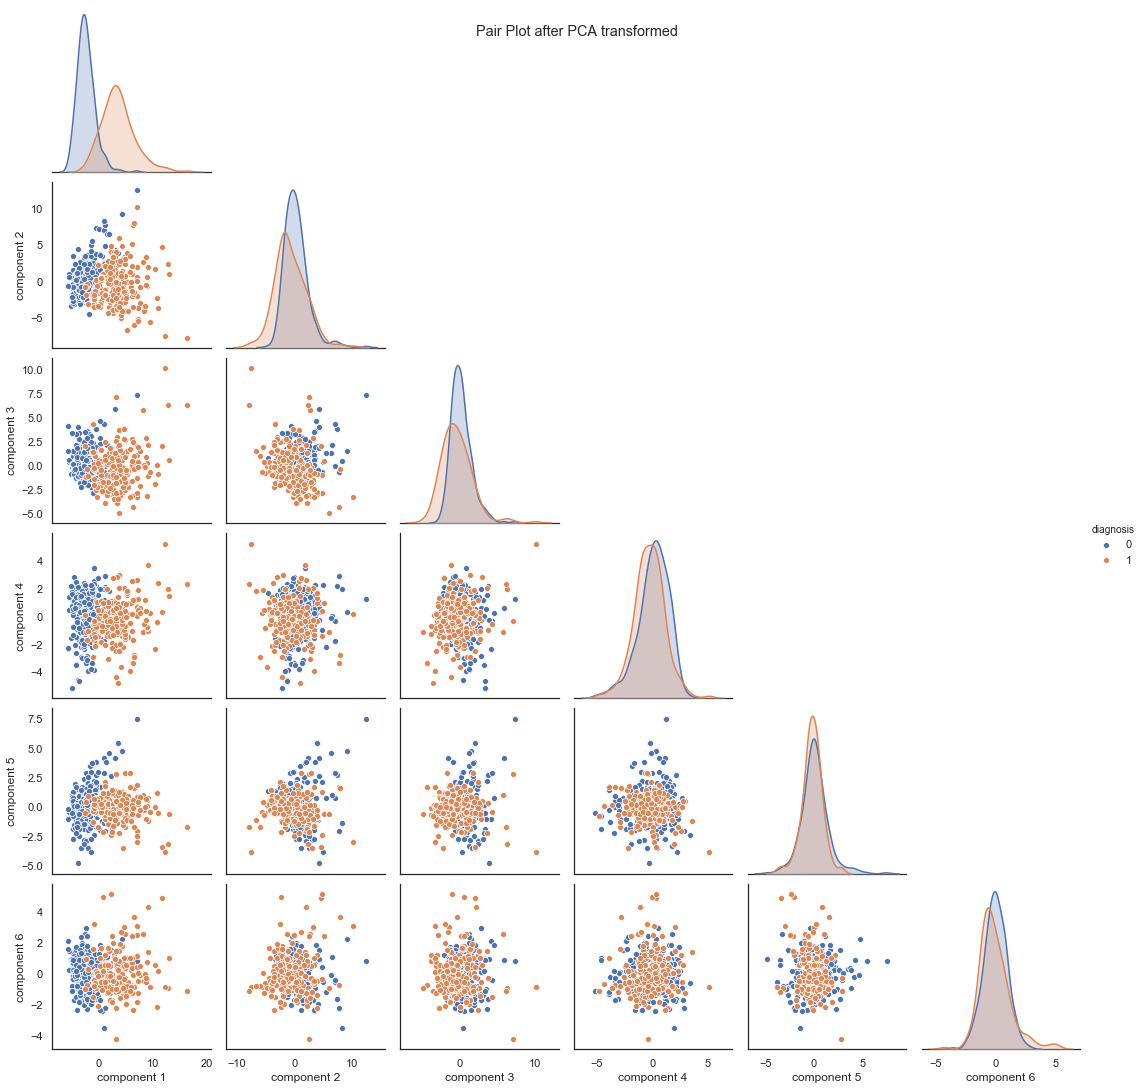

In [ ]:
print("Execute Random Forest with PCA components:")
display(PCA_Analysis(data))

### Report
- By using PCA, we achieves perfect precision where we can identify the positive case of cancer cells, and we don't falsely label cancer case. However, in turn, we ignore many false negative cases, which causes a low value in recall. Therefore, our accuracy and F1 scores suffer. 